In [ ]:
import pandas as pd
import pylab
%matplotlib inline
import matplotlib.pyplot as plt
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import norm
from scipy.stats import sem
import statistics
import numpy as np
import calendar
import seaborn as sns
import ast

from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px

# make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

#reading file
file_name = 'tmdb_5000_movies.csv'
tmdb_5000 = pd.read_csv(file_name)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 47.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


### Cleaning to Make Summary Stats

In [ ]:
#clean visual appearance of data (round numbers to 2 after decimal comma)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#create new dataframe with relevant variables for summary stats
tmdb_5000['release_date'] = pd.to_datetime(tmdb_5000['release_date'], errors='coerce')
tmdb_5000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                4803 non-null   int64         
 1   genres                4803 non-null   object        
 2   homepage              1712 non-null   object        
 3   id                    4803 non-null   int64         
 4   keywords              4803 non-null   object        
 5   original_language     4803 non-null   object        
 6   original_title        4803 non-null   object        
 7   overview              4800 non-null   object        
 8   popularity            4803 non-null   float64       
 9   production_companies  4803 non-null   object        
 10  production_countries  4803 non-null   object        
 11  release_date          4802 non-null   datetime64[ns]
 12  revenue               4803 non-null   int64         
 13  runtime           

### Double-check there are no duplicate rows

In [ ]:
#Check for posible duplicate rows
duplicate_rows = tmdb_5000[tmdb_5000.duplicated()]

#Count the number of duplicate rows to confirm (un-# last line)
num_duplicate_rows = len(duplicate_rows)
#print(f"\nNumber of Duplicate Rows: {num_duplicate_rows}")

### Get rid of irrelevant variables (Extended Version)

In [ ]:
#Get rid of homepage (wont be scrapping it, irrelevant), id (random number attributed to the movie), status (always released)

# main_columns = ['budget','genres','keywords','original_language','original_title','overview','production_companies','production_countries','spoken_languages','tagline','title','revenue','runtime','vote_average','vote_count','popularity','release_date']
main_columns = ['budget','genres','original_title','revenue','runtime','vote_average','vote_count','popularity','release_date']
tmdb_5000 = tmdb_5000.loc[:, main_columns]

#Double check with tmdb_5000.head() - all good!
tmdb_5000.head()

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                             original_title     revenue  runtime  \
0                                    Avatar  2787965087   162.00   
1  Pirates of the Caribbean: At World's End   961000000   169.00   
2                                   Spectre   880674609   148.00   
3                     The Dark Knight Rises  1084939099   165.00   
4                               John Carter   284139100   132.00   

   vote_average  vote_count  popularity release_date  
0          7.20       11800      150.44   2009-12-10  
1          6.90        4500      139.08   2007-05-19  
2          6.30        4466      107.38   2015-10-26  
3          7.60        9106      112.31   2012-07-16  
4          6.10        2124       43.93   2012-03-07

### How many null values is it SHOWING rn? 

In [ ]:
#Find out how many null values there are
# it should show 0 null values for all of them. 
# THIS IS BECAUSE it does not see '0' or '0.00' as null, it counts them as entries.
# we need to change all these to NaN formats so that this function can actually find all the missing values. 

print(tmdb_5000.isnull().sum())

budget            0
genres            0
original_title    0
revenue           0
runtime           2
vote_average      0
vote_count        0
popularity        0
release_date      1
dtype: int64


SO THESE ARE NOT 0: Runtime + Release_Date; So we need to convert them to NaN

### Fixing the 0 issue; changing to NaN

In [ ]:
# due to differences in formatting, we use 0 and 0.00 
tmdb_5000['budget'] = tmdb_5000['budget'].replace(0 , np.nan)
tmdb_5000['revenue'] = tmdb_5000['revenue'].replace(0 , np.nan)
tmdb_5000['runtime'] = tmdb_5000['runtime'].replace(0.00 , np.nan)
tmdb_5000['vote_average'] = tmdb_5000['vote_average'].replace(0.00 , np.nan)
tmdb_5000['vote_count'] = tmdb_5000['vote_count'].replace(0 , np.nan)
tmdb_5000['popularity'] = tmdb_5000['popularity'].replace(0.00 , np.nan)
tmdb_5000['release_date'] = tmdb_5000['release_date'].replace(0 , np.nan)

In [ ]:
#checking what changed
tmdb_5000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   budget          3766 non-null   float64       
 1   genres          4803 non-null   object        
 2   original_title  4803 non-null   object        
 3   revenue         3376 non-null   float64       
 4   runtime         4766 non-null   float64       
 5   vote_average    4740 non-null   float64       
 6   vote_count      4741 non-null   float64       
 7   popularity      4802 non-null   float64       
 8   release_date    4802 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 337.8+ KB


Now there are less non-null values; which means that the computer now recognises that 0 means a null value

dtypes have changed from int to float

In [ ]:
# now the no. of null values is accurate
print(tmdb_5000.isnull().sum())

budget            1037
genres               0
original_title       0
revenue           1427
runtime             37
vote_average        63
vote_count          62
popularity           1
release_date         1
dtype: int64


### Just Checking Revenue; check for no more 0s

In [ ]:
print(tmdb_5000['revenue'])
#fab, all out null values come out as NaN and no longer as just 0 as before.

3805             NaN
3806             NaN
3807             NaN
3808             NaN
3809             NaN
3810             NaN
3811     28350000.00
3812     23689877.00
3813    400176459.00
3814             NaN
3815        14873.00
3816      8000000.00
3817      4270000.00
3818             NaN
3819        44462.00
3820      2956000.00
3821             NaN
3822     13401952.00
3823     44785053.00
3824    257850122.00
3825     83453539.00
3826             NaN
3827     28215918.00
3828     27900000.00
3829     14000000.00
3830      5000000.00
3831     13007551.00
3832     12800000.00
3833     12000000.00
3834     12600000.00
3835     40423945.00
3836             NaN
3837      9482579.00
3838      6451628.00
3839     33965843.00
3840             NaN
3841      5923044.00
3842             NaN
3843             NaN
3844             NaN
3845      4159678.00
3846             NaN
3847       113783.00
3848             NaN
3849             NaN
3850             NaN
3851             NaN
3852         

### ---- GETTING RID OF BAD DATA in the tmdb_5000 df ---

### Budget

In [ ]:
#budget
tmdb_5000.sort_values(by='budget', ascending=True)

#there was a jump from £650 to £7000, I decided to make the cutoff there as all the films below were amateur films

tmdb_5000 = tmdb_5000[tmdb_5000['budget'] >= 7000]
# print to check
# tmdb_5000.sort_values(by='budget', ascending=True).head()

### Revenue

In [ ]:
tmdb_5000.sort_values(by='revenue', ascending=True)
#okay, there is a jump from £46 revenue to £3330 and I have checked the £3330 one & it's data is correct. gonna cut all those below it - inaccurate and amateur, not relevant to the type of movies we're interested in 
tmdb_5000 = tmdb_5000[tmdb_5000['revenue'] >= 3000]
#print to check
# tmdb_5000.sort_values(by='revenue', ascending=True).head() 

### Removing a Random Anomaly

In [ ]:
# Carlos (it's a short TV series not a movie.)
# runtime just under 6 hours.

tmdb_5000 = tmdb_5000.drop(2384, axis='index')

### Removing Bad Zero values in Budget, Revenue, and Runtime

In [ ]:
#Filtering out rows with zero or negative values in budget, revenue and runtime

tmdb_5000 = tmdb_5000[(tmdb_5000['revenue'] > 0) & (tmdb_5000['budget'] > 0) & (tmdb_5000['runtime'] > 0)]

#To confirm "zero" values have been removed from the dataframe
print(tmdb_5000.describe())

#Count zero values

zero_budget = (tmdb_5000['budget'] == 0).sum()
zero_revenue = (tmdb_5000['revenue'] == 0).sum()
zero_runtime = (tmdb_5000['runtime'] == 0).sum()

print(f'Number of zero values in budget: {zero_budget}')
print(f'Number of zero values in revenue: {zero_revenue}')
print(f'Number of zero values in runtime: {zero_runtime}')

            budget       revenue  runtime  vote_average  vote_count  \
count      3210.00       3210.00  3210.00       3208.00     3208.00   
mean   40870156.25  121954197.88   110.73          6.31      982.93   
std    44435557.26  186623198.10    20.57          0.86     1417.12   
min        7000.00       3330.00    41.00          2.30        1.00   
25%    11000000.00   17320698.25    96.00          5.80      182.00   
50%    25050000.00   56028877.00   107.00          6.30      478.00   
75%    55000000.00  147324213.00   121.00          6.90     1150.25   
max   380000000.00 2787965087.00   248.00          8.50    13752.00   

       popularity  
count     3210.00  
mean        29.17  
std         36.23  
min          0.02  
25%         10.61  
50%         20.56  
75%         37.48  
max        875.58  
Number of zero values in budget: 0
Number of zero values in revenue: 0
Number of zero values in runtime: 0


### Taking Only the First Genre

In [ ]:
# Convert String to Python object
tmdb_5000['genres'] = tmdb_5000['genres'].apply(ast.literal_eval)

# Extract the first element from each list (of genres)
tmdb_5000['first_genre'] = tmdb_5000['genres'].apply(lambda x: x[0]['name'] if x else None)

# Drop the original 'genres' column
tmdb_5000 = tmdb_5000.drop('genres', axis=1)

In [ ]:
# Display the result
print(tmdb_5000[['original_title', 'first_genre']].head())

                             original_title first_genre
0                                    Avatar      Action
1  Pirates of the Caribbean: At World's End   Adventure
2                                   Spectre      Action
3                     The Dark Knight Rises      Action
4                               John Carter      Action


### Removing the Year in Release Date

In [ ]:
# Extract month and day from the 'release_date' column
tmdb_5000['release_date'] = tmdb_5000['release_date'].dt.strftime('%m-%d')

# Display 'original_title' and 'release_date' columns for the first few rows
print(tmdb_5000[['original_title', 'release_date']].head(10))

#in mm-dd format

                             original_title release_date
0                                    Avatar        12-10
1  Pirates of the Caribbean: At World's End        05-19
2                                   Spectre        10-26
3                     The Dark Knight Rises        07-16
4                               John Carter        03-07
5                              Spider-Man 3        05-01
6                                   Tangled        11-24
7                   Avengers: Age of Ultron        04-22
8    Harry Potter and the Half-Blood Prince        07-07
9        Batman v Superman: Dawn of Justice        03-23


### Removing Null Values for all Variables

In [ ]:
budget_nulls = pd.DataFrame(tmdb_5000['budget']) 
revenue_nulls = pd.DataFrame(tmdb_5000['revenue'])
popularity_nulls = pd.DataFrame(tmdb_5000['popularity'])
vote_average_nulls = pd.DataFrame(tmdb_5000['vote_average'])
vote_count_nulls = pd.DataFrame(tmdb_5000['vote_count'])
runtime_nulls = pd.DataFrame(tmdb_5000['runtime'])
release_date_nulls = pd.DataFrame(tmdb_5000['release_date'])

In [ ]:
print(tmdb_5000[['original_title','revenue']].head())

                             original_title       revenue
0                                    Avatar 2787965087.00
1  Pirates of the Caribbean: At World's End  961000000.00
2                                   Spectre  880674609.00
3                     The Dark Knight Rises 1084939099.00
4                               John Carter  284139100.00


In [ ]:
# Check how many entries are non-null
budget_nulls.info()
revenue_nulls.info()
popularity_nulls.info()
vote_average_nulls.info()
vote_count_nulls.info()
runtime_nulls.info()
release_date_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 4798
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   budget  3210 non-null   float64
dtypes: float64(1)
memory usage: 50.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 4798
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  3210 non-null   float64
dtypes: float64(1)
memory usage: 50.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 4798
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   popularity  3210 non-null   float64
dtypes: float64(1)
memory usage: 50.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 4798
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vote_average  

In [ ]:
#Check if all the null values have been dropped  
print(budget_nulls.isnull().sum())
print(revenue_nulls.isnull().sum())
print(popularity_nulls.isnull().sum())
print(vote_average_nulls.isnull().sum())
print(vote_count_nulls.isnull().sum())
print(runtime_nulls.isnull().sum())
print(release_date_nulls.isnull().sum())

budget    0
dtype: int64
revenue    0
dtype: int64
popularity    0
dtype: int64
vote_average    2
dtype: int64
vote_count    2
dtype: int64
runtime    0
dtype: int64
release_date    0
dtype: int64


In [ ]:
# Delete all the rows with null values
budget_nulls = budget_nulls.dropna()
revenue_nulls = revenue_nulls.dropna()
popularity_nulls = popularity_nulls.dropna()
vote_average_nulls = vote_average_nulls.dropna()
vote_count_nulls = vote_count_nulls.dropna()
runtime_nulls = runtime_nulls.dropna()
release_date_nulls = release_date_nulls.dropna()

In [ ]:
budget_nulls2 = pd.concat([budget_nulls], ignore_index=True)
revenue_nulls2 = pd.concat([revenue_nulls], ignore_index=True)
popularity_nulls2 = pd.concat([popularity_nulls], ignore_index=True)
vote_average_nulls2 = pd.concat([vote_average_nulls], ignore_index=True)
vote_count_nulls2 = pd.concat([vote_count_nulls], ignore_index=True)
runtime_nulls2 = pd.concat([runtime_nulls], ignore_index=True)
release_date_nulls2 = pd.concat([release_date_nulls], ignore_index=True)

In [ ]:
print(tmdb_5000[['original_title','revenue']].head())

                             original_title       revenue
0                                    Avatar 2787965087.00
1  Pirates of the Caribbean: At World's End  961000000.00
2                                   Spectre  880674609.00
3                     The Dark Knight Rises 1084939099.00
4                               John Carter  284139100.00


In [ ]:
# #Check if all the null values have been dropped  
print(budget_nulls.isnull().sum())
print(revenue_nulls.isnull().sum())
print(popularity_nulls.isnull().sum())
print(vote_average_nulls.isnull().sum())
print(vote_count_nulls.isnull().sum())
print(runtime_nulls.isnull().sum())
print(release_date_nulls.isnull().sum())

budget    0
dtype: int64
revenue    0
dtype: int64
popularity    0
dtype: int64
vote_average    0
dtype: int64
vote_count    0
dtype: int64
runtime    0
dtype: int64
release_date    0
dtype: int64


In [ ]:
# #Check if all the null values have been dropped  
print(budget_nulls.isnull().sum())
print(revenue_nulls.isnull().sum())
print(popularity_nulls.isnull().sum())
print(vote_average_nulls.isnull().sum())
print(vote_count_nulls.isnull().sum())
print(runtime_nulls.isnull().sum())
print(release_date_nulls.isnull().sum())

budget    0
dtype: int64
revenue    0
dtype: int64
popularity    0
dtype: int64
vote_average    0
dtype: int64
vote_count    0
dtype: int64
runtime    0
dtype: int64
release_date    0
dtype: int64


In [ ]:
print(tmdb_5000.describe())

            budget       revenue  runtime  vote_average  vote_count  \
count      3210.00       3210.00  3210.00       3208.00     3208.00   
mean   40870156.25  121954197.88   110.73          6.31      982.93   
std    44435557.26  186623198.10    20.57          0.86     1417.12   
min        7000.00       3330.00    41.00          2.30        1.00   
25%    11000000.00   17320698.25    96.00          5.80      182.00   
50%    25050000.00   56028877.00   107.00          6.30      478.00   
75%    55000000.00  147324213.00   121.00          6.90     1150.25   
max   380000000.00 2787965087.00   248.00          8.50    13752.00   

       popularity  
count     3210.00  
mean        29.17  
std         36.23  
min          0.02  
25%         10.61  
50%         20.56  
75%         37.48  
max        875.58  


## Data Analysis

### Hypothesis Testing - Budget 

In [ ]:
# Hypothesis testing 
#(of budget against revenue) 
#Null hypothesis (H0): There is no significant relationship between the budget and revenue of movies in the TMDb top 5000 movies.
#Alternative hypothesis (H1): There is a significant relationship between the budget and revenue of movies in the TMDb top 5000 movies.

In [ ]:
def plot_z(test_statistic):
    mu, se= 0, 1 # create two variables, a mean "mu" equal to zero, and standard deviation "se" equal to 1
    x = np.linspace(mu - 3*se, mu + 3*se, 100) # create a range of values from -3 to 3 standard deviations

    plt.plot(x, norm.pdf(x, mu, se)) # plot the normal distribution
    plt.axvline(mu-se*1.96, color='blue', linestyle='dashed', linewidth=1.5,label='µ ± 1.96σ (95% confidence)') # plot a vertical line at the mean plus 2 standard deviations
    plt.axvline(mu+se*1.96, color='blue', linestyle='dashed', linewidth=1.5)  # plot a vertical line at the mean minus 2 standard deviations
    plt.axvline(mu-se*2.58, color='green', linestyle='dashed', linewidth=1.5,label='µ ± 2.58σ (99% confidence)') # plot a vertical line at the mean plus 2 standard deviations
    plt.axvline(mu+se*2.58, color='green', linestyle='dashed', linewidth=1.5)  # plot a vertical line at the mean minus 2 standard deviations

    plt.axvline(test_statistic, color='red', linestyle='solid', linewidth=1.5,label='Test Statistic') # plot a vertical line at the test statistic


    plt.ylim(0,0.4)
    plt.legend()
    plt.title('Z Distribution') # add a title
    plt.show()

# plot_z(-2.3)

In [ ]:
def manual_ttest(group1, group2, plot=False): # define a function called "manual_ttest" that takes two groups and a boolean value for whether or not to plot the results as arguments

    desc1, desc2=group1.describe(), group2.describe() # get descriptive statistics for both samples

    n1,std1,mean1 = desc1['count'], desc1['std'] ,desc1['mean'] # get the sample size, standard deviation, and mean of the first sample
    n2,std2,mean2 = desc2['count'], desc2['std'] ,desc2['mean'] # get the sample size, standard deviation, and mean of the second sample

    # calculate standard errors
    se1, se2 = std1**2/n1, std2**2/n2 # '**2' is the same as squaring the number

    # standard error on the difference between the samples
    sed = np.sqrt(se1 + se2)

    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed

    # print the results
    print("Group 1: n=%.0f, mean=%.3f, std=%.3f" % (n1,mean1,std1))
    print("Group 2: n=%.0f, mean=%.3f, std=%.3f" % (n2,mean2,std2))
    print('The t-statistic is %.3f' % t_stat) # print the t-statistic

    if plot==True: # if the plot argument is set to True, plot the results
        groups=pd.DataFrame() # create an empty dataframe
        i=1 # create a counter variable called "i" and set it equal to 1

        for group in [group1, group2]: # loop through each group in the list of groups
            plot_df=pd.DataFrame({'Values': group,'Group':i}) # create a dataframe with the values of the group and a column called "Group" that contains the group number
            groups=groups.append(plot_df) # append the dataframe to the list of dataframes
            i+=1 # increase the counter by 1

        sns.pointplot(data=groups , x='Group', y='Values',errorbar=('ci', 95), color='black', join=False, capsize=.8) # plot the means of the groups with a 95% confidence interval
        plt.title('Comparison of Group Means with 95% Confidence Intervals') # add a title

    return t_stat # return the t-statistic

In [ ]:
budget_t = manual_ttest(tmdb_5000['budget'],tmdb_5000['revenue']) # run the t-test function and store the t-statistic in a variable called "t"

Group 1: n=3210, mean=40870156.251, std=44435557.257
Group 2: n=3210, mean=121954197.880, std=186623198.102
The t-statistic is -23.947


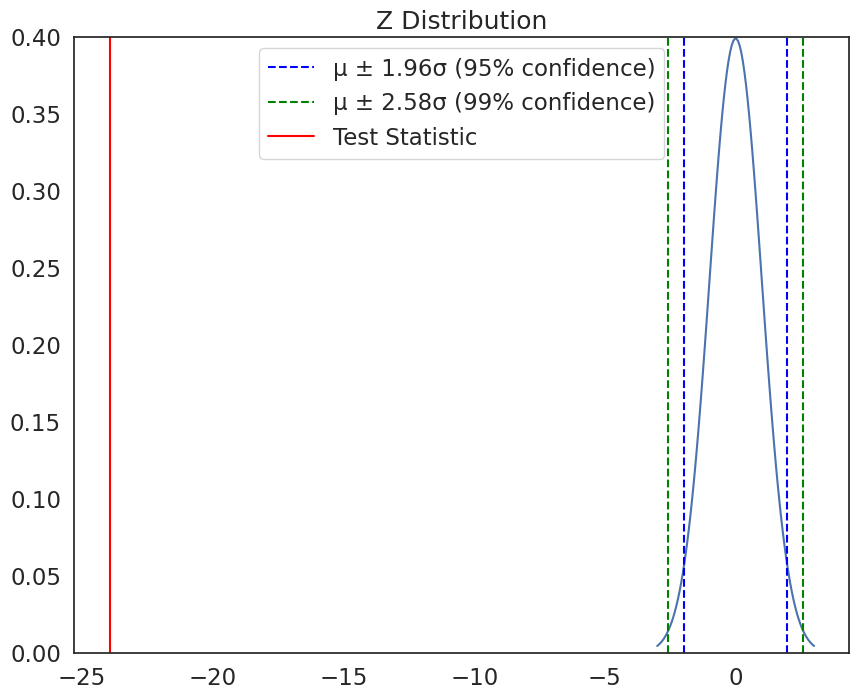

In [ ]:
plot_z(budget_t)

### Hypothesis Testing - Runtime

Null hypothesis (H0): There is no significant relationship between the runtime and revenue of movies in the TMDb top 5000 movies.

Alternative hypothesis (H1): There is a significant relationship between the runtime and revenue of movies in the TMDb top 5000 movies.

In [ ]:
runtime_t = manual_ttest(tmdb_5000['runtime'],tmdb_5000['revenue']) # run the t-test function and store the t-statistic in a variable called "t"

Group 1: n=3210, mean=110.725, std=20.566
Group 2: n=3210, mean=121954197.880, std=186623198.102
The t-statistic is -37.024


In [ ]:
# plot_z(runtime_t) # plot the test statistic on the z distributions

### Hypothesis Testing - Vote Average 

Null hypothesis (H0): There is no significant relationship between the vote average and revenue of movies in the TMDb top 5000 movies.

Alternative hypothesis (H1): There is a significant relationship between the vote average and revenue of movies in the TMDb top 5000 movies.

In [ ]:
vote_average_t = manual_ttest(tmdb_5000['vote_average'],tmdb_5000['revenue']) # run the t-test function and store the t-statistic in a variable called "vote_average_t"

Group 1: n=3208, mean=6.313, std=0.859
Group 2: n=3210, mean=121954197.880, std=186623198.102
The t-statistic is -37.024


In [ ]:
# plot_z(vote_average_t) # plot the test statistic on the z distributions

### Hypothesis Testing - Vote_Count

Null hypothesis (H0): There is no significant relationship between the vote count and revenue of movies in the TMDb top 5000 movies.

Alternative hypothesis (H1): There is a significant relationship between the vote count and revenue of movies in the TMDb top 5000 movies.

In [ ]:
vote_count_t = manual_ttest(tmdb_5000['vote_count'],tmdb_5000['revenue']) # run the t-test function and store the t-statistic in a variable called "vote_count_t"

Group 1: n=3208, mean=982.927, std=1417.118
Group 2: n=3210, mean=121954197.880, std=186623198.102
The t-statistic is -37.024


### Hypothesis Testing - Popularity 

In [ ]:
popularity_t = manual_ttest(tmdb_5000['popularity'],tmdb_5000['revenue']) # run the t-test function and store the t-statistic in a variable called "t"

Group 1: n=3210, mean=29.169, std=36.225
Group 2: n=3210, mean=121954197.880, std=186623198.102
The t-statistic is -37.024


### Initial Regression Bit

In [ ]:
tmdb_5000[['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity']] = tmdb_5000[['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity']].replace(0, pd.NA)

# Drop rows with NaN values
tmdb_5000.dropna(inplace=True)

print(tmdb_5000[['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity']].isnull().sum())

budget          0
revenue         0
runtime         0
vote_average    0
vote_count      0
popularity      0
dtype: int64


In [ ]:
#before outlier removal
tmdb_5000 = tmdb_5000.sort_values(by='revenue')
tmdb_5000.head()

budget                                     original_title  \
1999  25000000.00         The Adventurer: The Curse of the Midas Box   
4399   1000000.00                                            Special   
3121  10000000.00                                    Janky Promoters   
4772     31192.00                                       Down Terrace   
4397   1000000.00                                     Alone With Her   
3815   3800000.00                                       Major Dundee   
3120  10000000.00                                       Strangerland   
2901  20000000.00                                      5 Days of War   
2651  15000000.00                                     The Good Night   
3956   3000000.00                                         The Divide   
2650  15000000.00                                All The Queen's Men   
4306    900000.00                                 Pink Ribbons, Inc.   
3399   6000000.00                                The Boondock Saints   
4433    930000.00                                       L!fe Happens   
4596   6000000.00                                             Maniac   
4245   1500000.00                                          Pontypool   
3513   6000000.00                                           Song One   
3795    650000.00                                         Stake Land   
4619    300000.00                             First Love, Last Rites   
3819   3500000.00                                           Defendor   
3874   3300000.00                                       Opposite Sex   
3115  10000000.00        An Alan Smithee Film: Burn, Hollywood, Burn   
3397   7000000.00                                               Ca$h   
2714  14000000.00                                           Margaret   
3295   8000000.00                                              Aloft   
4128   2000000.00                        Return of the Living Dead 3   
4647    250000.00                                        The Canyons   
4461    800000.00                                      The Mudge Boy   
3507  12000000.00                                           Deadfall   
3502   6000000.00                                       Surfer, Dude   
4028   2500000.00                                 Eye of the Dolphin   
1101  65000000.00                                         Foodfight!   
2646  15000000.00                                     Silent Trigger   
4473    750000.00                                     The Innkeepers   
4138    100000.00                                           Stitches   
4539    500000.00                                             Rubber   
4792     20000.00                                                キュア   
3979   3000000.00                                       Freakonomics   
4032   2500000.00                                       Sleep Dealer   
1672  30000000.00                                               辛亥革命   
4666    225000.00                                               Burn   
4120   3800000.00                            Saint John of Las Vegas   
3847   3500000.00                                     Winter Passing   
3789   9500000.00                                              Trust   
4119   2000000.00                            It's All Gone Pete Tong   
2970  10500000.00                                 There Goes My Baby   
4117   2000000.00                                 Six-String Samurai   
3196   5000000.00                                         Opal Dream   
3293   8000000.00                                        10th & Wolf   
3794   4000000.00                                   Los lunes al sol   
4190    500000.00                                                May   
4472    500000.00                                          Kill List   
4240   1500000.00                                   My Name Is Bruce   
3742   4000000.00                                             Maggie   
4122  13500000.00                                  

In [ ]:
# remove outliers
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 3*iqr # calculate the lower bound
    high = q3 + 3*iqr # calculate the upper bound
    filtered = tmdb_5000[(var > low) & (var < high)] # filter the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

tmdb_5000=filter_outliers(tmdb_5000['revenue']) # filter outliers from revenue
tmdb_5000=filter_outliers(tmdb_5000['budget']) # filter outliers from revenue
tmdb_5000=filter_outliers(tmdb_5000['popularity'])
# can leave out vote_average bc there are no outliers votes are always within the 1-10 range
tmdb_5000=filter_outliers(tmdb_5000['vote_count'])
tmdb_5000=filter_outliers(tmdb_5000['runtime']) # filter outliers from revenue

Dropped 133 observations
Dropped 35 observations
Dropped 25 observations
Dropped 87 observations
Dropped 17 observations


In [ ]:
tmdb_5000.head()

budget                                     original_title  \
1999  25000000.00         The Adventurer: The Curse of the Midas Box   
4399   1000000.00                                            Special   
3121  10000000.00                                    Janky Promoters   
4772     31192.00                                       Down Terrace   
4397   1000000.00                                     Alone With Her   
3815   3800000.00                                       Major Dundee   
3120  10000000.00                                       Strangerland   
2901  20000000.00                                      5 Days of War   
2651  15000000.00                                     The Good Night   
3956   3000000.00                                         The Divide   
2650  15000000.00                                All The Queen's Men   
4306    900000.00                                 Pink Ribbons, Inc.   
3399   6000000.00                                The Boondock Saints   
4433    930000.00                                       L!fe Happens   
4596   6000000.00                                             Maniac   
4245   1500000.00                                          Pontypool   
3513   6000000.00                                           Song One   
3795    650000.00                                         Stake Land   
4619    300000.00                             First Love, Last Rites   
3819   3500000.00                                           Defendor   
3874   3300000.00                                       Opposite Sex   
3115  10000000.00        An Alan Smithee Film: Burn, Hollywood, Burn   
3397   7000000.00                                               Ca$h   
2714  14000000.00                                           Margaret   
3295   8000000.00                                              Aloft   
4128   2000000.00                        Return of the Living Dead 3   
4647    250000.00                                        The Canyons   
4461    800000.00                                      The Mudge Boy   
3507  12000000.00                                           Deadfall   
3502   6000000.00                                       Surfer, Dude   
4028   2500000.00                                 Eye of the Dolphin   
1101  65000000.00                                         Foodfight!   
2646  15000000.00                                     Silent Trigger   
4473    750000.00                                     The Innkeepers   
4138    100000.00                                           Stitches   
4539    500000.00                                             Rubber   
4792     20000.00                                                キュア   
3979   3000000.00                                       Freakonomics   
4032   2500000.00                                       Sleep Dealer   
1672  30000000.00                                               辛亥革命   
4666    225000.00                                               Burn   
4120   3800000.00                            Saint John of Las Vegas   
3847   3500000.00                                     Winter Passing   
3789   9500000.00                                              Trust   
4119   2000000.00                            It's All Gone Pete Tong   
2970  10500000.00                                 There Goes My Baby   
4117   2000000.00                                 Six-String Samurai   
3196   5000000.00                                         Opal Dream   
3293   8000000.00                                        10th & Wolf   
3794   4000000.00                                   Los lunes al sol   
4190    500000.00                                                May   
4472    500000.00                                          Kill List   
4240   1500000.00                                   My Name Is Bruce   
3742   4000000.00                                             Maggie   
4122  13500000.00                                  

### Assumptions (Homoscedasticity) - Budget

Text(69.75, 0.5, 'Box Office Revenue')

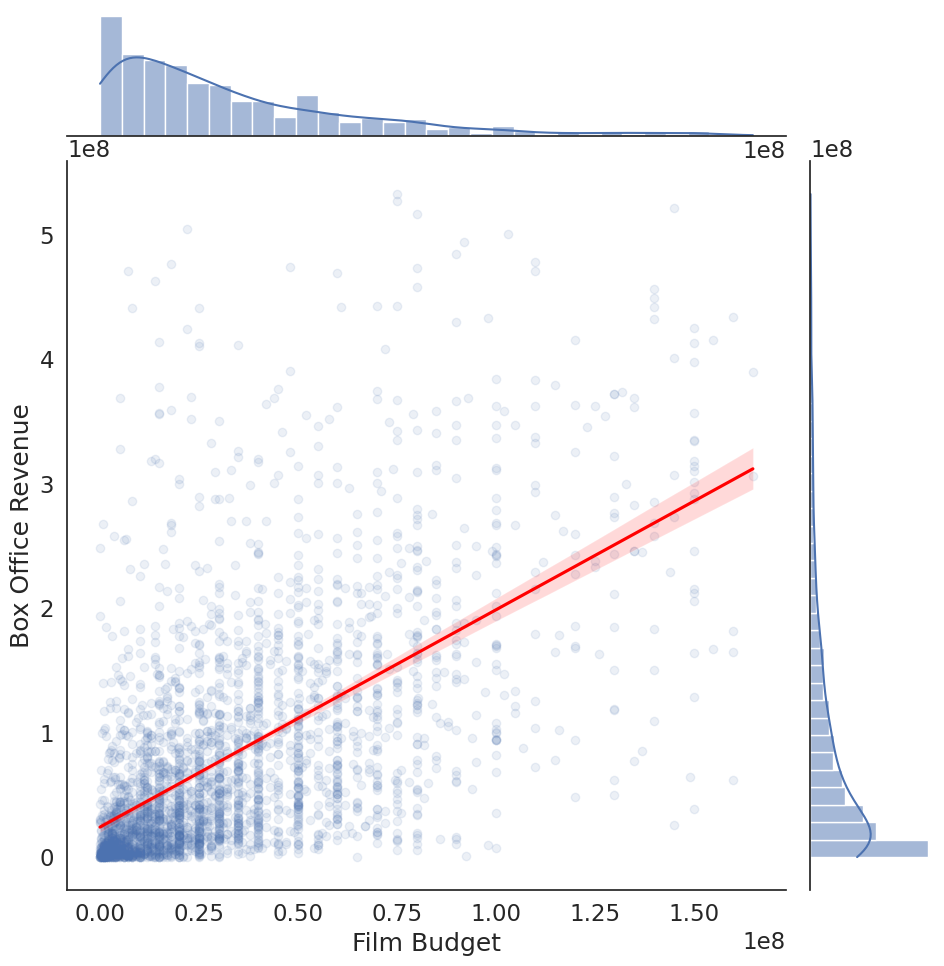

In [ ]:
# Homoscedasticity
sns.jointplot(data=tmdb_5000, # plot a scatterplot with a regression line and two histograms
                x='budget', # set the x axis to be the budget of the top tmdb_5000 movies
                y='revenue', # set the y axis to be the revenue of the top tmdb_5000 movies
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Film Budget') # add a label to the x axis
plt.ylabel('Box Office Revenue') # add a label to the y axis

### Assumptions (Homoscedasticity) - Runtime

Text(69.75, 0.5, 'Box Office Revenue')

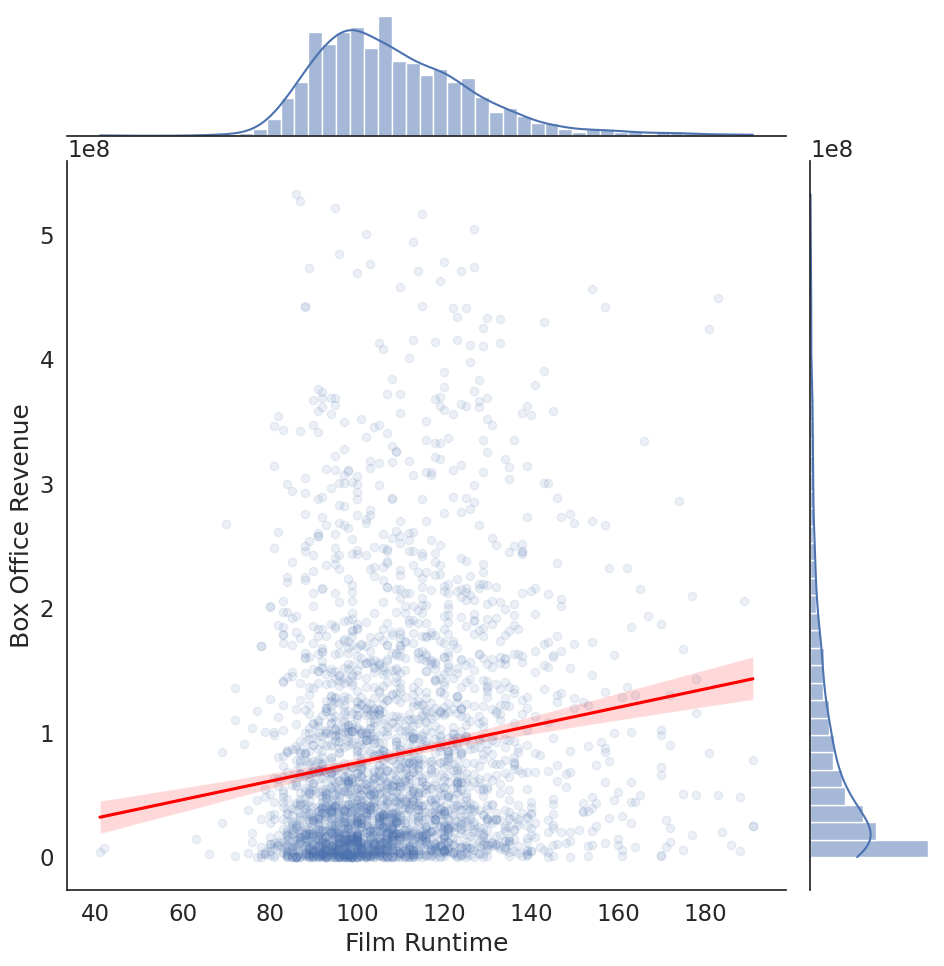

In [ ]:
sns.jointplot(data=tmdb_5000, # plot a scatterplot with a regression line and two histograms
                x='runtime', # set the x axis to be the runtime of the top tmdb_5000 movies
                y='revenue', # set the y axis to be the revenue of the top tmdb_5000 movies
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Film Runtime') # add a label to the x axis
plt.ylabel('Box Office Revenue') # add a label to the y axis

### Assumptions (Homoscedasticity) - Vote Average

Text(69.75, 0.5, 'Box Office Revenue')

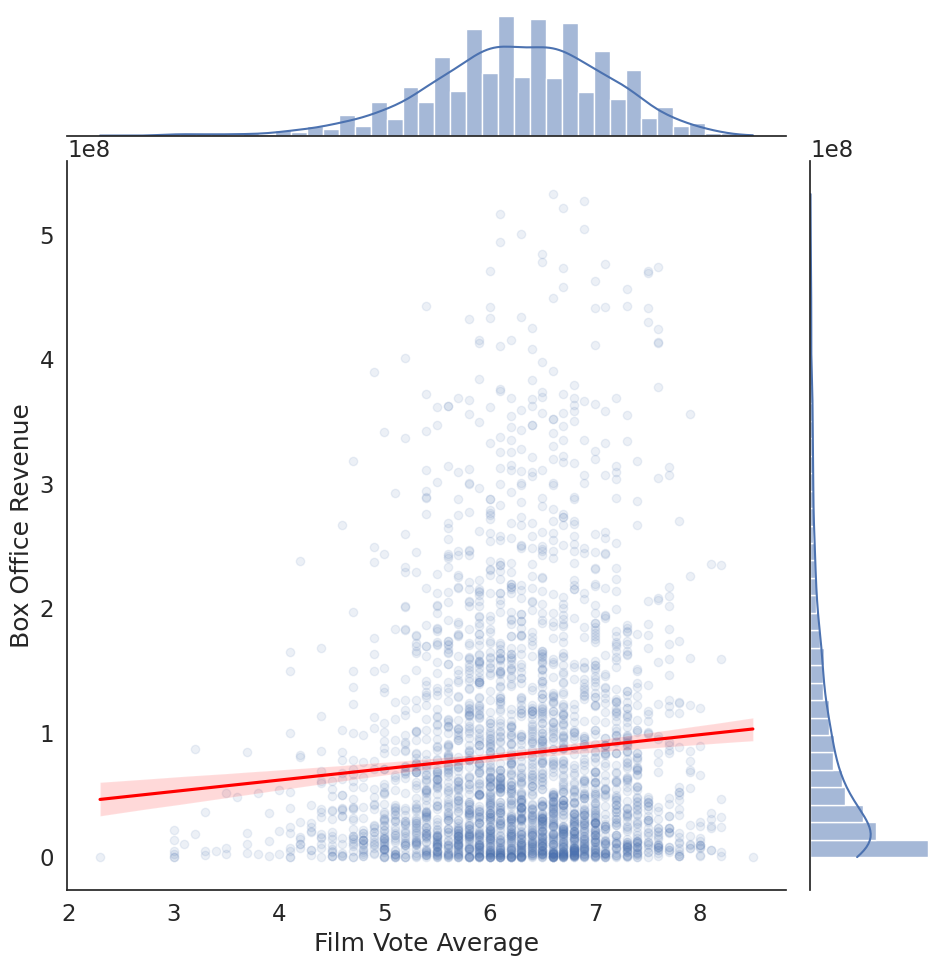

In [ ]:
sns.jointplot(data=tmdb_5000, # plot a scatterplot with a regression line and two histograms
                x='vote_average', # set the x axis to be the vote average of the top tmdb_5000 movies
                y='revenue', # set the y axis to be the revenue of the top tmdb_5000 movies
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Film Vote Average') # add a label to the x axis
plt.ylabel('Box Office Revenue') # add a label to the y axis

### Assumptions (Homoscedasticity) - Vote Count

Text(69.75, 0.5, 'Box Office Revenue')

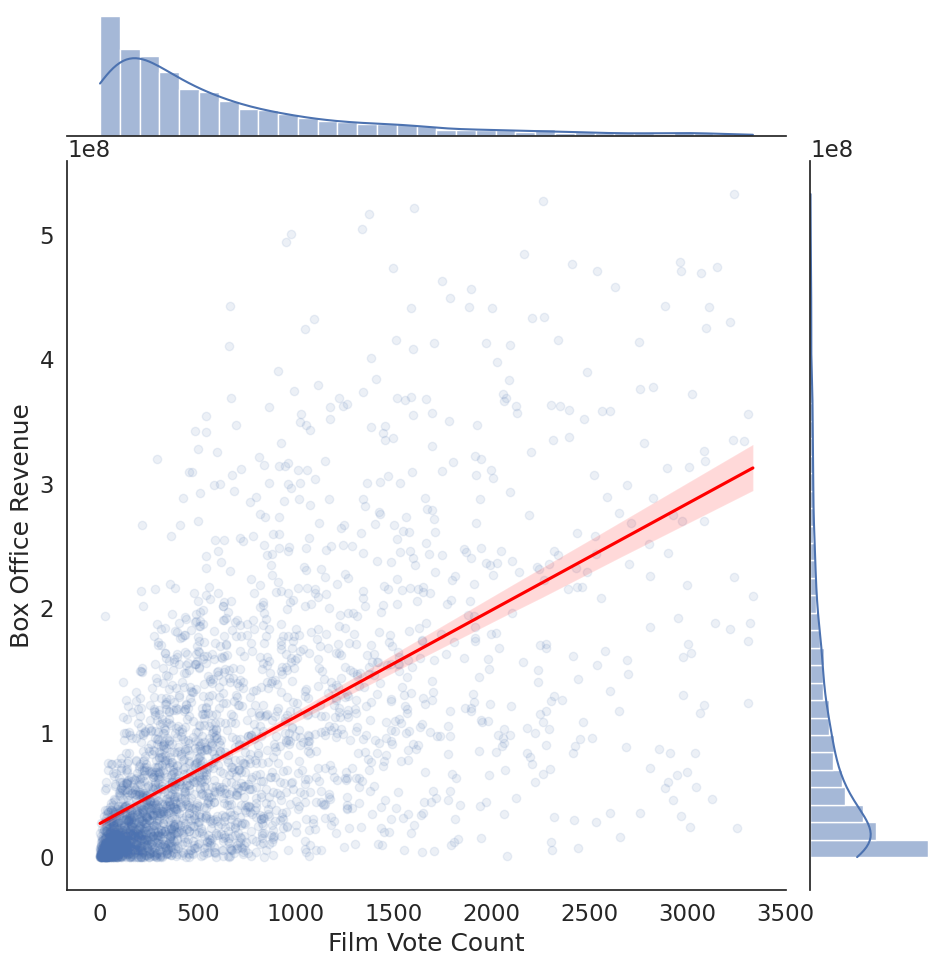

In [ ]:
sns.jointplot(data=tmdb_5000, # plot a scatterplot with a regression line and two histograms
                x='vote_count', # set the x axis to be the vote count of the top tmdb_5000 movies
                y='revenue', # set the y axis to be the revenue of the top tmdb_5000 movies
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Film Vote Count') # add a label to the x axis
plt.ylabel('Box Office Revenue') # add a label to the y axis

### Assumptions (Homoscedasticity) - Popularity 

Text(69.75, 0.5, 'Box Office Revenue')

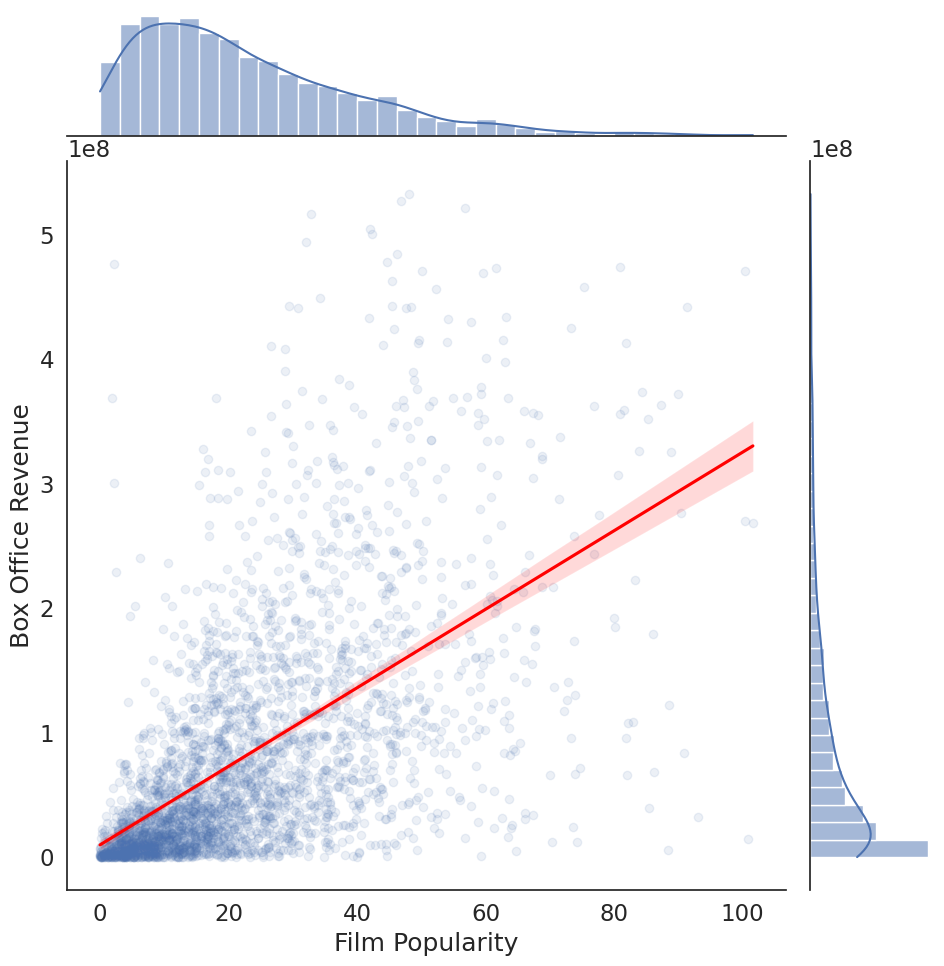

In [ ]:
sns.jointplot(data=tmdb_5000, # plot a scatterplot with a regression line and two histograms
                x='popularity', # set the x axis to be the popularity of the top tmdb_5000 movies
                y='revenue', # set the y axis to be the revenue of the top tmdb_5000 movies
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Film Popularity') # add a label to the x axis
plt.ylabel('Box Office Revenue') # add a label to the y axis

### Assumptions (Multicollinearity) 

Text(0.5, 1.0, 'Correlation Matrix')

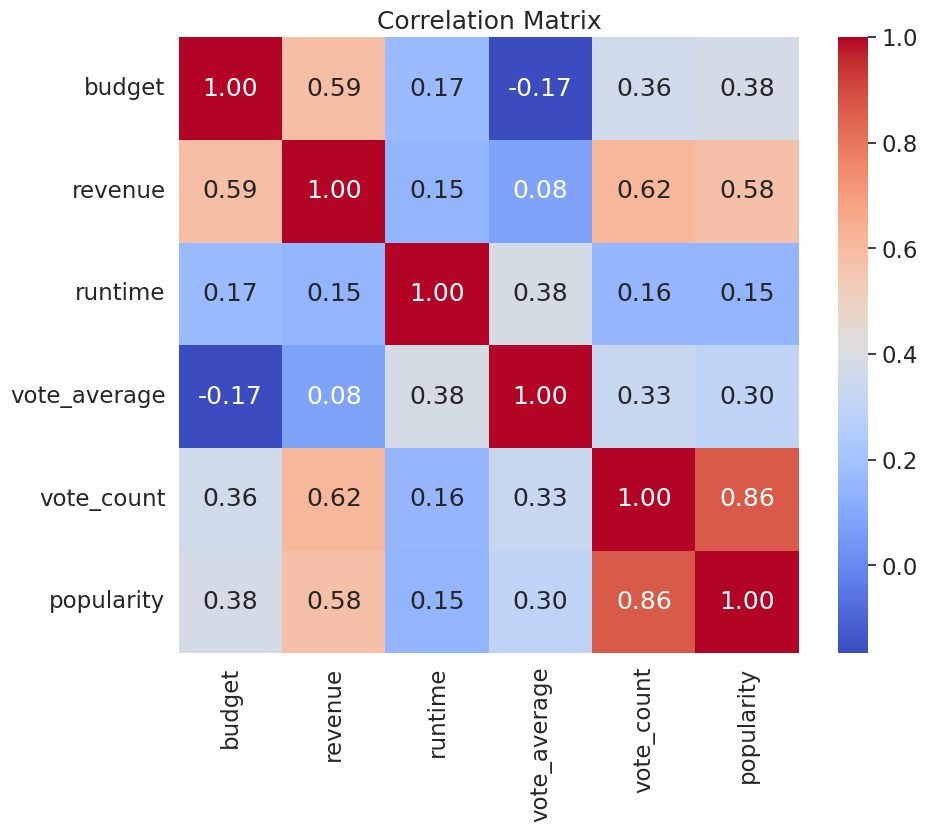

In [ ]:
sns.heatmap(tmdb_5000.corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [ ]:
def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [ ]:
#VIF
ind_vars=['budget','revenue','runtime','vote_average','vote_count','popularity']

vif = drop_column_using_vif_(tmdb_5000[ind_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 4.466264079423605
The columns remaining after VIF selection are:
Index(['budget', 'revenue', 'runtime', 'vote_average', 'vote_count',
       'popularity'],
      dtype='object')


### Regression - Full Model

In [ ]:
all_cat_reg = ols('revenue ~ budget + runtime + vote_average + vote_count + popularity + C(first_genre) + C(release_date)', data=tmdb_5000).fit()
print(all_cat_reg.summary()) # print the summary
# base cat is an action 
# base cat released on 1 Jan

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     11.04
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:52:39   Log-Likelihood:                -56102.
No. Observations:                2910   AIC:                         1.130e+05
Df Residuals:                    2522   BIC:                         1.153e+05
Df Model:                         387                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### Budget Regression Graph

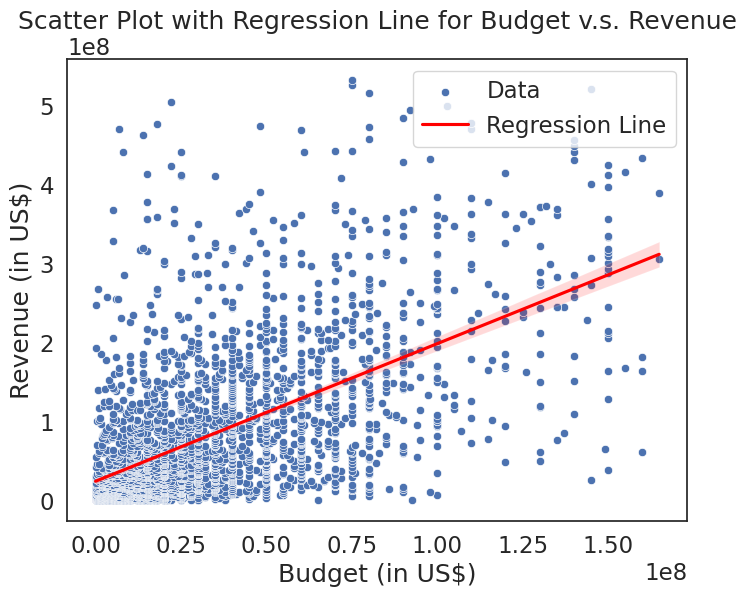

In [ ]:
# Scatter plot with regression line for 'budget' and 'revenue'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='revenue', data=tmdb_5000, label='Data')

# Regression line
sns.regplot(x='budget', y='revenue', data=tmdb_5000, scatter=False, color='red', label='Regression Line')

plt.title('Scatter Plot with Regression Line for Budget v.s. Revenue')
plt.xlabel('Budget (in US$)')
plt.ylabel('Revenue (in US$)')
plt.legend()
plt.show()

### Runtime Reg Graph

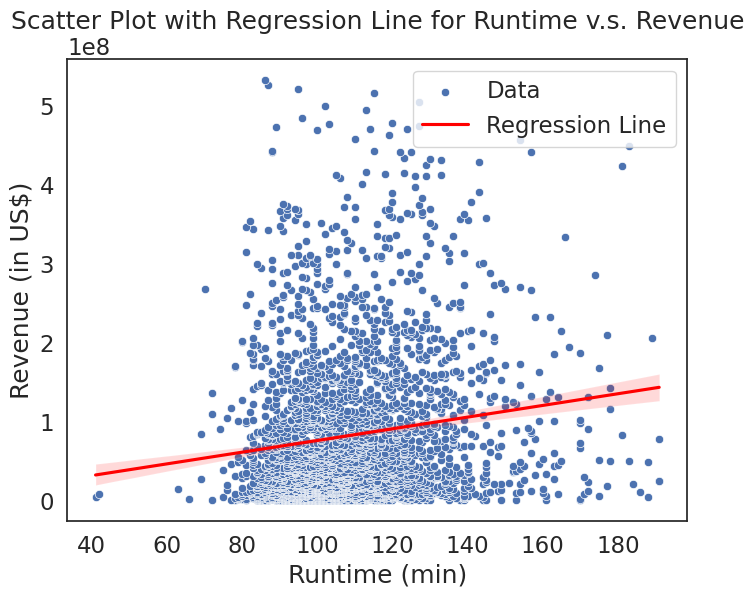

In [ ]:
# Scatter plot with regression line for 'runtime' and 'revenue'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='runtime', y='revenue', data=tmdb_5000, label='Data')

# Regression line
sns.regplot(x='runtime', y='revenue', data=tmdb_5000, scatter=False, color='red', label='Regression Line')

plt.title('Scatter Plot with Regression Line for Runtime v.s. Revenue')
plt.xlabel('Runtime (min)')
plt.ylabel('Revenue (in US$)')
plt.legend()
plt.show()

### Vote Average Reg Graph

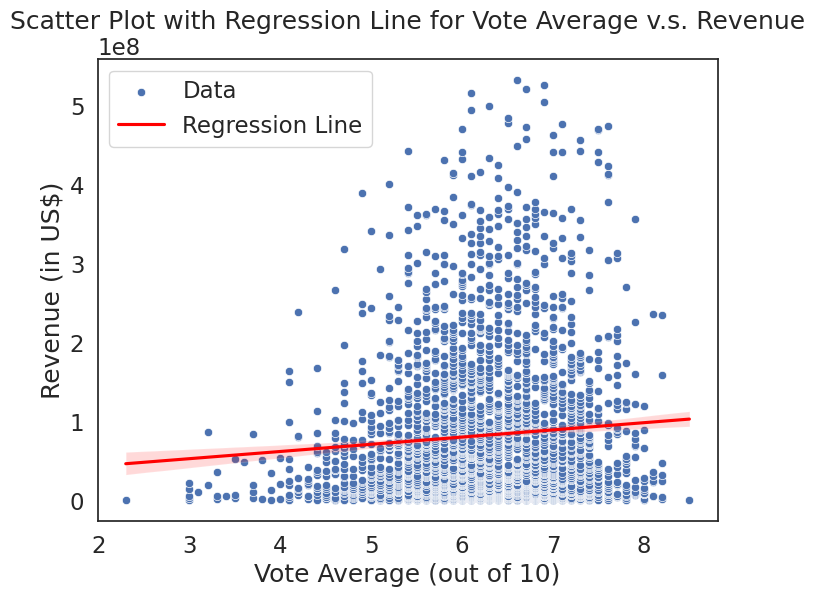

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='vote_average', y='revenue', data=tmdb_5000, label='Data')

# Regression line
sns.regplot(x='vote_average', y='revenue', data=tmdb_5000, scatter=False, color='red', label='Regression Line')

plt.title('Scatter Plot with Regression Line for Vote Average v.s. Revenue')
plt.xlabel('Vote Average (out of 10)')
plt.ylabel('Revenue (in US$)')
plt.legend()
plt.show()

### Vote Count Reg Graph

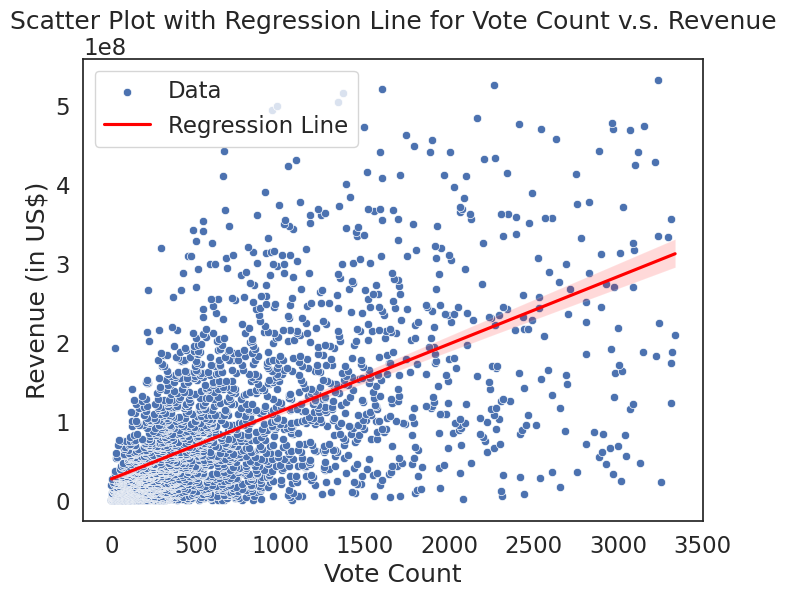

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='vote_count', y='revenue', data=tmdb_5000, label='Data')

# Regression line
sns.regplot(x='vote_count', y='revenue', data=tmdb_5000, scatter=False, color='red', label='Regression Line')

plt.title('Scatter Plot with Regression Line for Vote Count v.s. Revenue')
plt.xlabel('Vote Count')
plt.ylabel('Revenue (in US$)')
plt.legend()
plt.show()

### Popularity Reg Graph

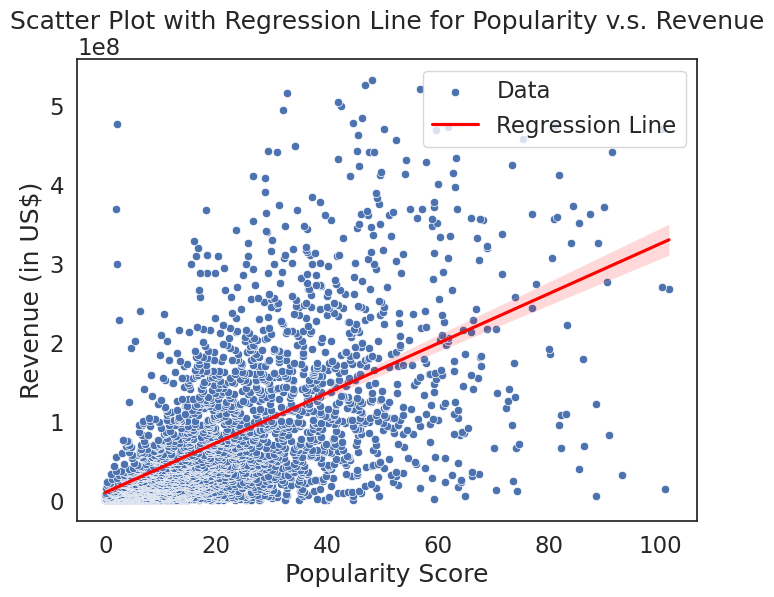

In [ ]:
#pop reg graph
plt.figure(figsize=(8, 6))
sns.scatterplot(x='popularity', y='revenue', data=tmdb_5000, label='Data')

# Regression line
sns.regplot(x='popularity', y='revenue', data=tmdb_5000, scatter=False, color='red', label='Regression Line')

plt.title('Scatter Plot with Regression Line for Popularity v.s. Revenue')
plt.xlabel('Popularity Score')
plt.ylabel('Revenue (in US$)')
plt.legend()
plt.show()

### Genre - Box Plot

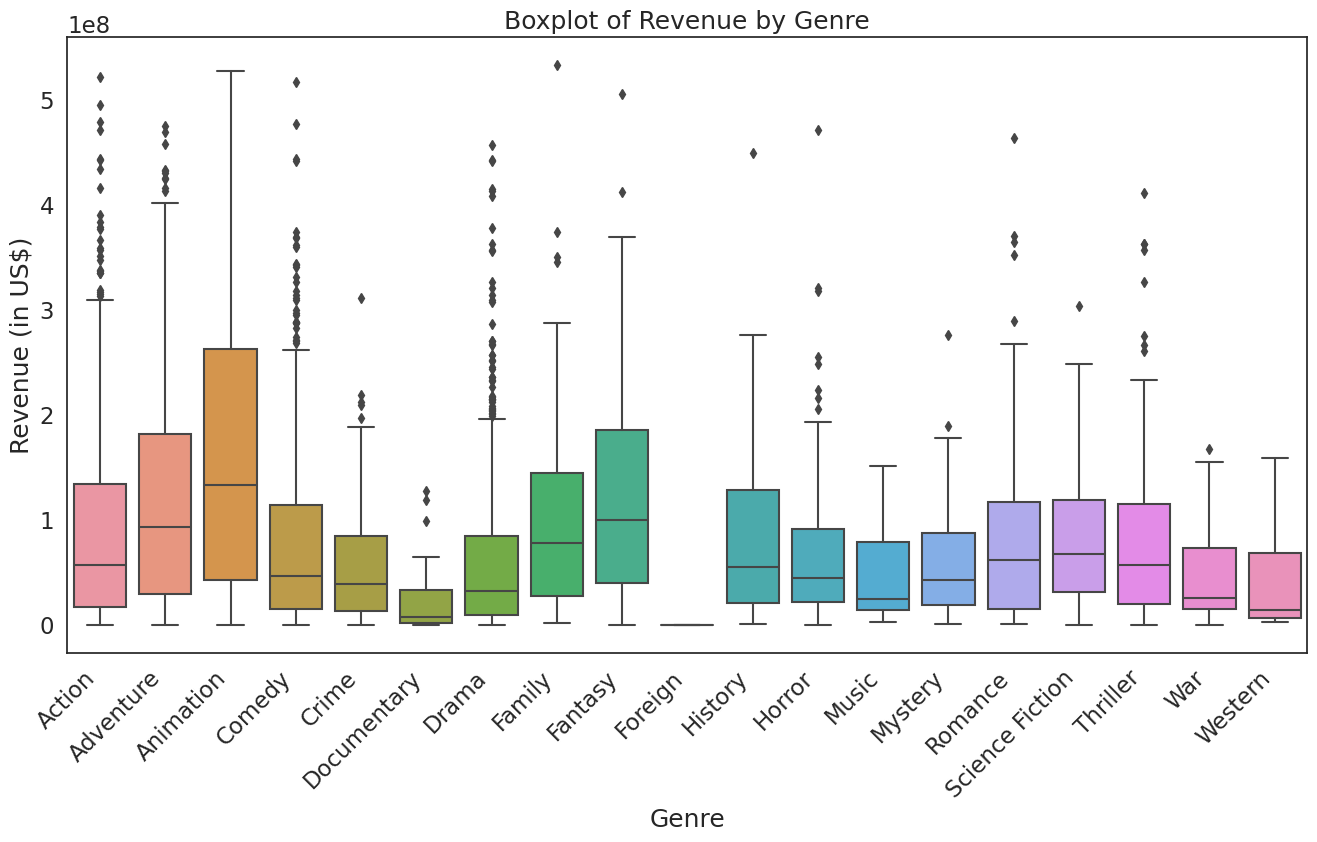

In [ ]:
plt.figure(figsize=(16, 8))

# Specify the order of genres for alphabetical sorting
genre_order = sorted(tmdb_5000['first_genre'].unique(), key=lambda x: (x is None, x))
sns.boxplot(x='first_genre', y='revenue', data=tmdb_5000, order=genre_order)

plt.title('Boxplot of Revenue by Genre')
plt.xlabel('Genre')
plt.ylabel('Revenue (in US$)')
plt.xticks(rotation=45, ha='right')  # Rotate genre labels for better visibility
plt.show()

### Release Date - Box Plot

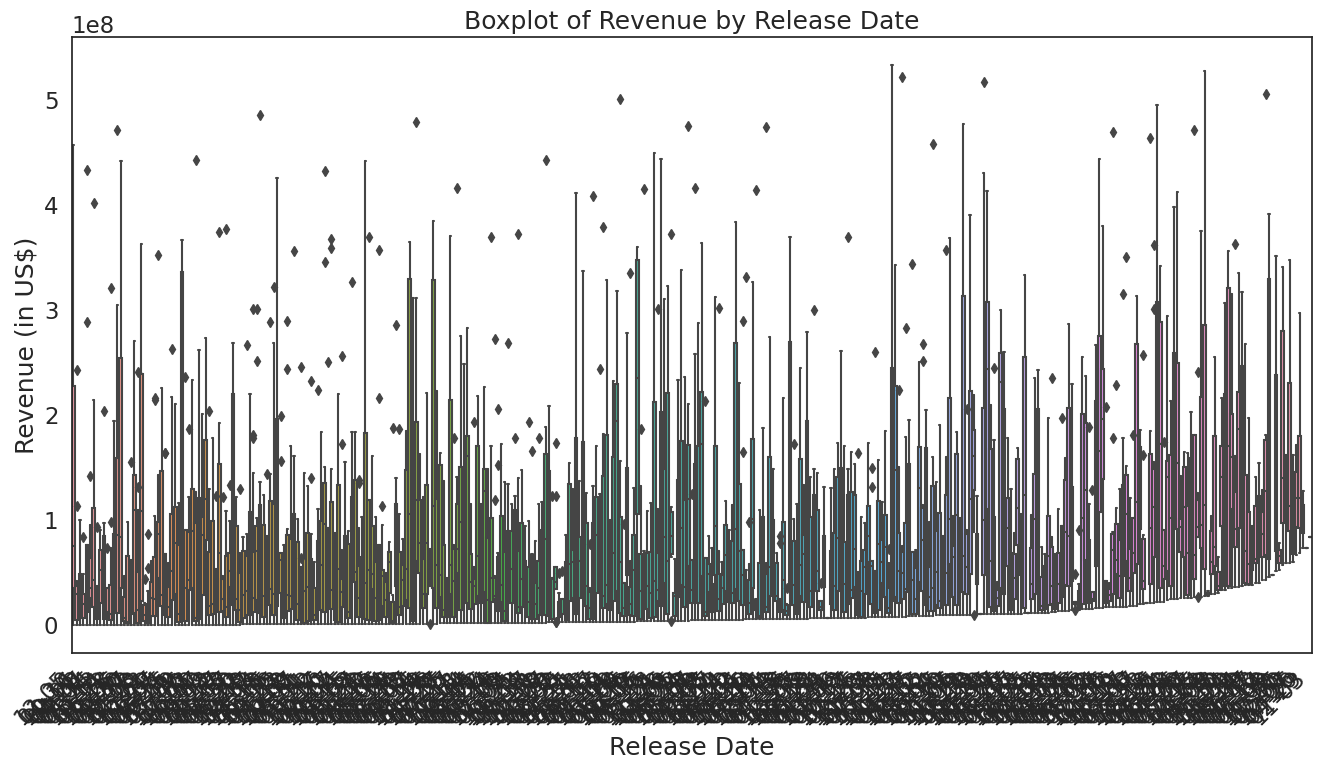

In [ ]:
plt.figure(figsize=(16, 8))

sns.boxplot(x='release_date', y='revenue', data=tmdb_5000)

plt.title('Boxplot of Revenue by Release Date')
plt.xlabel('Release Date')
plt.ylabel('Revenue (in US$)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=27ecc207-c200-45a0-9ca8-694d4235510b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>